In [73]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c pmldl-week-2-tools-and-processes

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


# Practical machine learning and deep learning. Lab 2
# Tools and Processes for Machine Learning and Data Analysis

## [Competition](https://www.kaggle.com/t/2f4a0677739348a3905f63b1b64da35c)

### Goal
Your goal is to familiarize yourself with tools for data processing, model training and inference, and ways to log model metrics

## Submission
Your goal is to implement small neural network to classify images and generate `submission.csv` for the test set

## Libraries

### Frameworks

#### PyTorch
   PyTorch is an open-source machine learning library primarily developed by Facebook's AI Research lab. It is widely used for deep learning tasks.

#### TensorFlow
   TensorFlow is an open-source machine learning framework developed by Google. It's designed for building and training deep neural networks.

### Logging
#### Tensorboard
   TensorBoard is a visualization tool provided by TensorFlow for monitoring and visualizing the training process and model performance during machine learning experiments.

#### WandB (Weights & Biases)
   Weights & Biases is a platform that provides tools for tracking, visualizing, and optimizing machine learning experiments

#### ClearML
   ClearML is an open-source machine learning platform designed to automate and streamline the end-to-end machine learning workflow, including data management, model training, and deployment.

### Data Preprocessing
   Data preprocessing involves cleaning, transforming, and organizing raw data to make it suitable for analysis or machine learning. This step is essential for improving data quality and model performance.

#### Pandas
   Pandas is an open-source data manipulation and analysis library for Python. It provides data structures like DataFrames and Series, making it easy to work with structured data.

#### Matplotlib
   Matplotlib is a Python library for creating static, animated, and interactive visualizations in various formats. It's commonly used for data visualization and plotting.

#### Torchvision
   Torchvision is a PyTorch library that offers datasets, transformations, and models for computer vision tasks.

#### Torchtext
Torchtext is a PyTorch library that offers datasets, transformations, and models for natural language processing tasks.

In [74]:
# We will use tensorboard as logging tool. However kaggle does not allow to view it.
!pip install tensorboard

In [75]:
import warnings
warnings.filterwarnings("ignore")

## Data preprocessing

In [76]:
# necessary imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter

In [77]:
# read train data
train_df = pd.read_csv('mnist_train.csv', header=None)
train_df.head()


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
# split images and labels
labels = train_df[0].values
images = train_df.drop(0, axis=1).values.reshape(-1, 28, 28) / 255

In [79]:
# Preprocess images
import torchvision.transforms as transforms

transform = transforms.Compose(
    [
        #   Here you can add more augmentations.
        #   See documentation: https://pytorch.org/vision/stable/transforms.html
        transforms.ToTensor(),
        transforms.Normalize(mean=0, std=1)
    ]
)


In [82]:
# convert data to tensors
images = [transform(image).float() for image in images]
images = torch.stack(images)
labels = torch.from_numpy(labels)


In [83]:
# just some checking of shapes
images.shape, labels.shape


(torch.Size([60000, 1, 28, 28]), torch.Size([60000]))

In [84]:
import matplotlib.pyplot as plt


def plot_images(images, captions=[], rows=2, columns=5, title="", **kwargs):
    """
    Plots images with captions

    :param images: list of images to plot
    :param captions: captions of images:
    :param rows: number of rows in figure
    :param columns: number of columns:
    :param title: super title of figure
    """
    fig = plt.figure(figsize=(6, 3))
    for i, img in enumerate(images):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(img, **kwargs)
        if i < len(captions):
            plt.title(captions[i])
        plt.axis("off")
    fig.suptitle(title)
    plt.show()


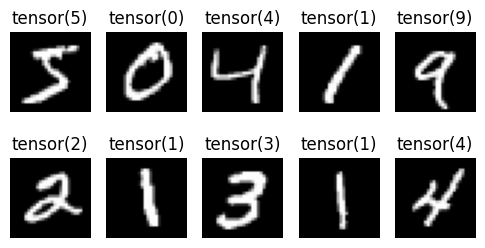

In [85]:
# Visualise 10 images from the dataset
plot_images(images[:10,0], captions=labels[:10], cmap='gray')


In [86]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

processed_dataset = TensorDataset(images, labels)

# set proportion and split dataset into train and validation parts
proportion = 0.1
train_dataset, val_dataset = train_test_split(processed_dataset, test_size=proportion)

In [87]:
# Create Dataloaders for training
# Dataloader is iterable object over dataset
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


## Model
We will implement MLP(multi-layer perceptron).

> if you want higher score implement any suitable model you know and like

In [88]:
class ClassificationModel(nn.Module):
    """
    MLP (multi-layer perceptron) based classification model for MNIST
    """

    def __init__(self, num_classes=10):
        super(ClassificationModel, self).__init__()

        # Add fully connected layers to nn.Sequential to create MLP
        # First layer should take 28x28 vector
        # last layer should return vector of size num_classes
        # do not forget to add activation function between layers

        self.model = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.model(x)


## Training

Here is the sample function for training procedure.
We save the checkpoints with best accuracy score. For the inference you need to load it to the model.

> You can add early stopping if you want for better results

In [89]:
def train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    writer,
    epochs=1,
    device="cpu",
    ckpt_path="best.pt",
):
    # best score for checkpointing
    best = 0.0

    # iterating over epochs
    for epoch in range(epochs):
        # training loop description
        train_loop = tqdm(
            enumerate(train_loader, 0), total=len(train_loader), desc=f"Epoch {epoch}"
        )
        model.to(device)
        model.train()
        train_loss = 0.0
        # iterate over dataset
        for i, data in train_loop:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass and loss calculation
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # backward pass
            loss.backward()

            # optimizer run
            optimizer.step()

            train_loss += loss.item()
            train_loop.set_postfix({"loss": loss.item()})

        # write loss to tensorboard
        writer.add_scalar("Loss/train", train_loss / len(train_loader), epoch)

        # validation
        correct = 0
        total = 0
        with torch.no_grad():
            model.eval()  # evaluation mode
            val_loop = tqdm(enumerate(val_loader, 0), total=len(val_loader), desc="Val")
            for i, data in val_loop:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted==labels).sum().item()

                val_loop.set_postfix({"acc": correct / total})

            if correct / total > best:
                torch.save(model.state_dict(), ckpt_path)
                best = correct / total


In [90]:
model = ClassificationModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()
device = 'cuda' if torch.cuda.is_available else 'cpu'
writer = SummaryWriter()


In [91]:
train(
    model,
    optimizer,
    loss_fn,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    writer=writer,
)


Epoch 0:   0%|          | 0/1688 [00:00<?, ?it/s]

Val:   0%|          | 0/188 [00:00<?, ?it/s]

In [ ]:
# Kaggle has no support of viewing tensorboard. Run this if you are using your machine
# to see logs.
# !tensorboard --logdir .

Tensorboard should like this
![image.png](attachment:64eae3ee-3ef9-478d-9eea-a29cf116b9f2.png)

## Inference
Here you need to perform inference of trained model on test data.

Load the best checkpoint from training to the model and run inference

In [92]:
# load best checkpoint to model
model = ClassificationModel()
ckpt = torch.load("best.pt")
model.load_state_dict(ckpt)

<All keys matched successfully>

In [103]:
def predict(model, test_loader, device):
    """
    Run model inference on test data
    """
    predictions = []
    with torch.no_grad():
        model.to(device)
        model.eval()  # evaluation mode
        test_loop = tqdm(enumerate(test_loader, 0), total=len(test_loader), desc="Test")
        for i, inputs in test_loop:
            inputs = torch.stack(inputs).to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.tolist())
        return predictions


In [101]:
# read test data
test_df = pd.read_csv('mnist_test.csv', header=None)
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
# process test data and run inference on it
images = test_df.values.reshape(-1,28, 28)/255
images = torch.stack([transform(image).float() for image in images])
test_loader = DataLoader(TensorDataset(images), batch_size=batch_size)
predictions = predict(model, test_loader, device='cpu')

Test:   0%|          | 0/313 [00:00<?, ?it/s]

In [105]:
# generate the submission file
submission_df = pd.DataFrame(columns=['id', 'label'])
submission_df['id'] = test_df.index
submission_df['label'] = predictions
submission_df.to_csv('submission.csv', index=None)